# Building the Recommendation system

In this notebook, I am building a table for the consine dist for both content

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances
from sklearn.feature_selection.variance_threshold import VarianceThreshold
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from collections import Counter

# Content: 

Import Game Meta Data

In [2]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./GB_API_Scrape//game_meta_data/') if isfile(join('./GB_API_Scrape//game_meta_data/', f))] #get list of files
list_of_meta = [] # fill this list with dictionaries 
feature_list = ['guid', 'name', 'concepts', 'themes', 'deck', 'developers', 'publishers', 'genres'] #list of features I care about
for file in onlyfiles:
    #looping through files, open them, put their contents into a dict, and add it to the list
    with open(f'./GB_API_Scrape//game_meta_data/{file}', 'r') as f:
        game = json.load(f)
        game_dict = {key:value for key, value in game.items() if key in feature_list}

        # convert lists to strings 
        for key, value in game_dict.items():
            if type(value) == list:
                game_dict[key] = ', '.join(value)
        list_of_meta.append(game_dict)
# make pandas dataframe
df = pd.DataFrame(list_of_meta)
df.fillna("", inplace=True)

## Here we have the raw data frame.  We need to:
* Dummy the columns 
* Drop features that are too sparse
* Drop games that have too few features

In [3]:
df.head()

,concepts,deck,developers,genres,guid,name,publishers,themes
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,,
1,,Zeal is an indie online ARPG developed by Lyca...,Lycanic Studios,"Action, Role-Playing, MOBA",3030-68714,Zeal,,"Fantasy, Medieval"
2,,Vertical Drop Heroes HD is an action platformer.,Nerdook Productions,"Action, Role-Playing, Platformer",3030-48249,Vertical Drop Heroes HD,,Fantasy
3,"Unreal Engine 4, PlayStation VR Support",A puzzle mystery game for PS VR.,Tarsier Studios,Puzzle,3030-57976,Statik,,
4,,A compilation of all three Banner Saga titles.,Stoic,"Strategy, Role-Playing, Compilation",3030-68731,The Banner Saga Trilogy,,Fantasy


In [4]:
def split_features_from_col(df, col):
    '''
    Returns a dataframe of 1 hot encoded features from the selected col 
    '''
    df[col] = ['' if entry == None else entry for entry in df[col] ]
    cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
    bow = cvec.fit_transform(df[col])
    ret_df  = pd.DataFrame(bow.todense(),
                       columns=map(lambda x: col + "_" + x, cvec.get_feature_names()))
    ret_df.drop(col+'_', 1, inplace=True)
    return ret_df

def split_features(df, list_of_cols):
    '''
    Returns a dataframe of 1 hot encoded features from a list of cols
    '''
    ret_df = df.loc[:, ['name', 'guid']]
    for col in list_of_cols:
        ret_df = pd.merge(ret_df, split_features_from_col(df, col), left_index=True, right_index=True)
        
    return ret_df

In [5]:
# We have 4 features that we want to split
dummied_df = split_features(df, ['concepts', 'genres', 'themes', 'developers'])

In [6]:
dummied_df.shape

(1746, 5072)

##  Manual Feature Reduction

In [7]:
dummied_df.var().sort_values(ascending=False)[0:20]

concepts_digital distribution    0.236484
concepts_steam                   0.193403
themes_fantasy                   0.171660
genres_action                    0.169722
themes_sci-fi                    0.154435
concepts_indie                   0.128014
concepts_steam achievements      0.127613
genres_adventure                 0.114020
genres_role-playing              0.111472
concepts_achievements            0.108037
genres_platformer                0.104998
genres_action-adventure          0.104123
concepts_playstation trophies    0.102367
concepts_steam trading cards     0.100156
concepts_gog.com                 0.097034
concepts_2d                      0.093879
concepts_voice acting            0.090693
themes_comedy                    0.088397
concepts_male protagonists       0.084689
genres_puzzle                    0.081881
dtype: float64

I don't want features like concepts_digital distribution or concepts_steam.\* or concepts_pax.\* or concepts_e3.\*

In [8]:
drop_cols = ["concepts_digital distribution"]
for col in dummied_df.columns:
    if ("concepts_steam" in col) or ("concepts_pax" in col) or ("concepts_e3" in col):
        drop_cols.append(col)
drop_cols[0:10]
print(f"Dropping {len(drop_cols)} columns")

Dropping 54 columns


In [9]:
dummied_df.drop(drop_cols, 1, inplace=True)

### Dropping games with too few (5 or less) features

In [10]:
thresh = 6
(dummied_df.iloc[:,2:].T.sum()>=thresh).sum()

1097

In [11]:
dummied_df.drop(dummied_df[dummied_df.iloc[:,2:].T.sum()<thresh].index, 0, inplace=True)

In [12]:
dummied_df.set_index("name", inplace=True)

In [13]:
dummied_df.drop("guid", 1, inplace=True)

In [14]:
dummied_df.shape

(1097, 5016)

## Using Sklearn's Variance Threshold to drop features with variance of .005 and less

In [15]:
vt = VarianceThreshold(.005)
thresh_df = vt.fit_transform(dummied_df)

In [16]:
thresh_df.shape

(1097, 1214)

## Using TruncatedSVD to condense 1214 features into 150 components.  
150 components explains 74% of the variance

In [17]:
svd = TruncatedSVD(n_components=150)
content = svd.fit_transform(thresh_df)

<Container object of 150 artists>

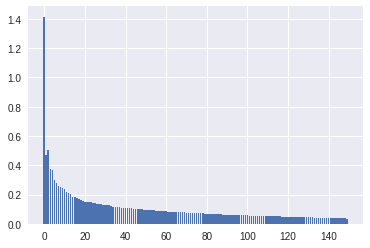

In [18]:
plt.bar(range(150),svd.explained_variance_)

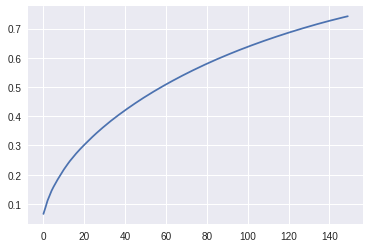

In [19]:
plt.plot(range(150), np.cumsum(svd.explained_variance_ratio_))

# Now to make the simularity matrix
* uses cosine distance
* simularity matrix stored in pandas dataframe called `distance_df`


In [20]:
sparse_content = sparse.csr_matrix(content)

In [21]:
distances = pairwise_distances(content, metric='cosine') 
distance_df = pd.DataFrame(distances, index=dummied_df.index, columns=dummied_df.index)
distance_df.head()

name,Kill the Bad Guy,Zeal,Giana Sisters: Twisted Dreams,Warriors All-Stars,Ultra Street Fighter IV,Arcania: Gothic 4,Lichdom: Battlemage,The King of Fighters Collection: The Orochi Saga,Alien Shooter,JumpJet Rex,...,Alienation,World Heroes 2 JET,Way of Redemption,Mystereet F: Tantei-tachi no Curtain Call,Hotline Miami 2: Wrong Number,The Magic Circle,Gran Turismo Sport,Guts and Glory,Mighty No. 9,Sonic Forces
name,,,,,,,,,,,,,,,,,,,,,
Kill the Bad Guy,0.000000,0.978199,0.825618,1.014190,0.872995,0.921146,0.995766,1.009096,0.976556,1.014306,...,0.957869,0.996987,1.019170,0.998209,0.957836,0.980697,1.030605,1.027174,0.916695,0.977628
Zeal,0.978199,0.000000,0.934319,0.487563,1.012192,0.756049,0.500531,1.012192,0.809204,1.008336,...,0.995783,1.000855,0.432768,0.990797,0.864137,0.796216,0.994696,0.980154,0.881339,0.829145
Giana Sisters: Twisted Dreams,0.825618,0.934319,0.000000,0.924187,0.840163,0.881668,0.920170,1.001243,0.958576,0.809863,...,0.883003,0.994864,0.937035,0.993760,0.880805,0.921098,0.994085,0.917323,0.703323,0.753291
Warriors All-Stars,1.014190,0.487563,0.924187,0.000000,0.940749,0.944137,0.730326,0.869447,0.879576,1.055383,...,1.021109,0.988570,0.486553,1.001148,0.859728,0.819226,1.005107,1.040812,0.945948,0.762020
Ultra Street Fighter IV,0.872995,1.012192,0.840163,0.940749,0.000000,0.911902,0.856463,0.797041,0.979927,0.881597,...,0.921085,0.759502,1.008670,0.948804,1.022598,0.965358,0.982897,0.991643,0.909809,0.980951


In [22]:
# Functions that interact with the content filter

def getSimilarGames(game, num=10):
    '''
    This function searches for a game and returns the similar games
    '''
    return get_simular_games_from_title(search_game(game)[0], num)

def search_game(search): # Added to class
    '''
    This helper function looks for games that match the search and returns them as a list
    '''
    return [game for game in distance_df.columns if search.lower() in game.lower() ]

def get_simular_games_from_title(title, num):
    '''
    This helper function returns the top num similar games given a title
    '''
    return distance_df[title].sort_values(ascending=True).index[1:num+1]

# requires the dummied_df, and needs to be run through vt and svd (maybe use a pipe)
def get_feature_vec(game):
    '''
    This function returns the binary vector associated with the feature space of a single game entry in the dummied dataframe
    '''
    title = search_game(game)[0]
    return dummied_df.loc[title, :].values

def combine_vec(v1, v2, method = 'or'):
    '''
    combines 2 feature vectors in the specified method
    method = {'union', 'and', 'or', 'intersect', 'add'}
    '''
    # add = v1+v2
    # XOR = (v1+v2) %2
    # or = (v1+v2)>0
    # and/intersect = (v1*v2) 
    
    if method == 'or' or method == 'union':
        return ((v1+v2)>0).astype(int)
    if method == 'and' or method == 'intersect':
        return v1*v2
    if method == 'add':
        return v1+v2

def transform_vector(vector):
    '''
    Given a binary vector of features, returns the transformed vector after feature reduction
    '''
    return svd.transform(vt.transform(vector.reshape(1, -1)))

# Requires content
def getCosineToVector(vector):
    '''
    returns a vector of cosine distances from a custom transformed vector to every game
    '''
    return cosine_distances(vector, content)

def getSimilarFeatures(game1, game2):
    '''
    Prints the simularity score and common features between @param game1 and @param game2
    '''
    vec1 = dummied_df.loc[search_game(game1)[0], :]
    vec2 = dummied_df.loc[search_game(game2)[0], :] 
    
    common = vec1 & vec2
    common = common[common==1]

    print("Simularity Score:")
    print()
    print(distance_df.loc[game1, game2])
    print()
    
    print("Number of features:")
    print((vec1.sum(), vec2.sum()))
    print()
    
    print("Number of Common Features:")
    print()
    print(len(common))
    print()
    
    print("Common features:")
    print()
    print(common)
    


In [23]:
getSimilarGames("Last of us")

Index(['Uncharted 4: A Thief's End', 'Metal Gear Solid V: The Phantom Pain',
       'Grand Theft Auto V', 'Fallout 4', 'Resident Evil 5',
       'The Walking Dead', 'Resident Evil', 'Resident Evil: Revelations',
       'God of War', 'Rise of the Tomb Raider'],
      dtype='object', name='name')

In [24]:
# getSimilarFeatures( "The Last of Us", "Grand Theft Auto V")

In [25]:
# distance_df.to_csv("./sim_matrix.csv")

In [26]:
# pd.read_csv("./sim_matrix.csv", index_col="name").head()

## Multiple game search without using the class

In [27]:
# get the combined feature vectors
combo = combine_vec(get_feature_vec("Fez"), get_feature_vec("N++"))

In [28]:
# combo = combine_vec(combo, get_feature_vec("the last of us"), "add")

In [29]:
# find the cosine distances to all the games
dists = getCosineToVector(transform_vector(combo))

In [30]:
# put in a series to identify the games
pd.Series(dists[0], index=distance_df.index).sort_values()[0:10]

name
Fez              0.028611
Celeste          0.525409
Badland          0.526874
VVVVVV           0.563615
N++              0.606898
The Bridge       0.608850
Ninja Senki      0.615310
Machinarium      0.620123
Escape Goat 2    0.621264
Kero Blaster     0.640147
dtype: float64

## Here is a class for custom searches.  To use it, you instantiate the class with a list of the games you want to include in the search, then call get

In [43]:
class CustomSearch(object):
    
    features_df = dummied_df
    content = content
    svd = svd
    vt = vt
    
    def __init__(self, games, combination_type = "or"):
        self.boolop = combination_type
        if type(games) == type([]):
            self.search_list=[]
            for game in games:
                title = self.search_game(game)
                self.search_list.append(title)
        else:
            title = self.search_game(games)
            self.search_list = [title]
        
    def search_game(self, search):
        '''
        This helper function looks for games that match the search and returns them as a list
        '''
        return [game for game in CustomSearch.features_df.index if search.lower() in game.lower()][0]
    
    def get_single_feature_vec(self, title):
        '''
        This helper function returns the binary vector associated with the feature space of a single game entry in the dummied dataframe
        '''
        return CustomSearch.features_df.loc[title, :].values
    
    def combine_vec(self, v1, v2, method = 'or'):
        '''
        combines 2 feature vectors in the specified method
        method = {'union', 'and', 'or', 'intersect', 'add'}
        '''
        # add = v1+v2
        # XOR = (v1+v2) %2
        # or = (v1+v2)>0
        # and/intersect = (v1*v2) 

        if method == 'or' or method == 'union':
            return ((v1+v2)>0).astype(int)
        if method == 'and' or method == 'intersect':
            return v1*v2
        if method == 'add':
            return v1+v2

    def getFeatureVector(self):
        ret_vec = self.get_single_feature_vec(self.search_list[0])
        if len(self.search_list) >1:
            for game in self.search_list[1:]:
                ret_vec = self.combine_vec(ret_vec, self.get_single_feature_vec(game))
        return ret_vec
            

    def transform_vector(self, vector):
        '''
        Given a binary vector of features, returns the transformed vector after feature reduction
        '''
        return CustomSearch.svd.transform(CustomSearch.vt.transform(vector.reshape(1, -1)))

    
    # Requires content
    def getCosineToVector(self):
        '''
        returns a vector of cosine distances from a custom transformed vector to every game
        '''
        vector = self.getFeatureVector()
        tvec = self.transform_vector(vector)
        return cosine_distances(tvec, content)

    def SearchSimilarGames(self, n=10):
        '''
        Returns an ordered array of the top n most similar games to the current search feature vector
        '''
        return [game for game in pd.Series(self.getCosineToVector()[0], index=distance_df.index).sort_values().index if game not in self.search_list][0:10]

In [44]:
testClass = CustomSearch(["uncharted 4", "tomb raider"])

In [45]:
testClass.SearchSimilarGames()

['Uncharted: The Nathan Drake Collection',
 'Hitman',
 "Tom Clancy's The Division",
 'inFamous: First Light',
 'Middle-earth: Shadow of War',
 'The Last of Us',
 'Metal Gear Solid V: The Phantom Pain',
 'Bloodborne',
 'Star Wars Battlefront',
 'Resident Evil: Code: Veronica']

In [46]:
CustomSearch(["Fez", "N++", "Celeste"]).SearchSimilarGames()

['Badland',
 'VVVVVV',
 'Kero Blaster',
 'Ninja Senki',
 'The Bridge',
 'Mutant Mudds',
 'Mark of the Ninja',
 'Escape Goat 2',
 'Giana Sisters: Twisted Dreams',
 'Stealth Bastard Deluxe']

#### TODO:
* write pickles for appropriate objects
* write class file in server's directory
    * Make the static vars read from pickles
* implement multisearch in site
* 

features_df = dummied_df
content = content
svd = svd
vt = vt

In [47]:
import pickle as pkl


In [48]:
with open("./model_assets/features_df.pkl", "wb+") as f:
    pkl.dump(dummied_df, f)

with open("./model_assets/content.pkl", "wb+") as f:
    pkl.dump(content, f)

with open("./model_assets/svd.pkl", "wb+") as f:
    pkl.dump(svd, f)

with open("./model_assets/vt.pkl", "wb+") as f:
    pkl.dump(vt, f)

In [ ]:
pkl.load()